In [1]:
if __name__ == '__main__':
    import sys; import os
    root_dir = 'Transmon-Project'
    root_path = os.path.abspath('').split(root_dir)[0] + root_dir
    sys.path.append(root_path)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

from circuit_models.direct_coupling_circuit import DCCircuit

plt.style.use('science')

## Estimating Depolarisation Times

In [3]:
circuit = DCCircuit(ncut=3)

# T1 = circuit.calc_T1()
Tphi = circuit.calc_Tphi()
# print(T1)
print(Tphi)

1.3707256283383048e-06


## Lifetimes

In [2]:
diff_param = 0.01
ng0 = 0.5

sys = DCCircuit(ncut=3)
sys.calc_D(ng0=0.5, diff_param=0.01)

/home/daniel/anaconda3/envs/main/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
Amp_ng_noise = 1e-4
omega_low = 2 * np.pi
t_exp = 10e-6

T_phi = 1 / (Amp_ng_noise * sys.D_omega01  * np.sqrt(2 * np.abs(np.log(omega_low) * t_exp)))
print(T_phi)

1.737354661565999e-05


## Estimating Dephasing Times

### Simulate $1/f$ Time Series

In [29]:
def generate_trajectory():
    dt = 1e-3
    N = int(1e6 + 1)
    df = 1 / (N * dt)
    Nf = int((N + 1) / 2)
    Amp = 1e-3
    psd_f = np.linspace(df * 1e-5, Nf * df, Nf)
    x0 = np.random.normal()
    t = np.linspace(0, N * dt, N + 1)

    f_ir = 1
    k_ir = np.argmin(abs(psd_f - f_ir))
    f_uv = 1e3
    k_uv = np.argmin(abs(psd_f - f_uv))

    data = np.insert(2**-0.5 * (np.random.normal(size=(Nf - 1)) + 1j * np.random.normal(size=(Nf - 1))), 0, x0)

    psd = np.append(np.zeros(k_ir), np.append((Amp / psd_f)[k_ir:k_uv], np.zeros(Nf - k_uv)))

    amp_filter = np.sqrt(np.append(psd, np.flip(psd)) * df * 0.5)
    data_f = np.append(data, np.conjugate(np.flip(data)))

    data_f_filtered = amp_filter * data_f

    delta_ngs = np.fft.ifft(data_f_filtered)

    return t, delta_ngs, data_f_filtered, amp_filter, data_f, psd_f, psd

/home/daniel/anaconda3/envs/main/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/daniel/anaconda3/envs/main/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


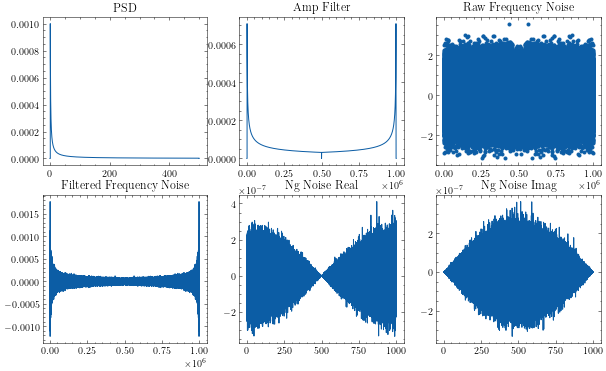

In [30]:
t, delta_ngs, data_f_filtered, amp_filter, data_f, psd_f, psd = generate_trajectory()

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2,3,1)
ax1.set_title('PSD')
ax1.plot(psd_f, psd)

ax2 = fig.add_subplot(2,3,2)
ax2.set_title('Amp Filter')
ax2.plot(amp_filter)

ax3 = fig.add_subplot(2,3,3)
ax3.set_title('Raw Frequency Noise')
ax3.plot(data_f, '.')

ax4 = fig.add_subplot(2,3,4)
ax4.set_title('Filtered Frequency Noise')
ax4.plot(data_f_filtered)

ax5 = fig.add_subplot(2,3,5)
ax5.set_title('Ng Noise Real')
ax5.plot(t, np.real(delta_ngs))

ax6 = fig.add_subplot(2,3,6)
ax6.set_title('Ng Noise Imag')
ax6.plot(t, np.imag(delta_ngs))

plt.show()

In [22]:
sys = DCCircuit(ncut=3)

rho_01s = []
n_cut = 200

for _ in range(10):
    rho_01 = []
    acc_phase = 0
    t, delta_ngs, _, _, _, _, _ = generate_trajectory()
    t, delta_ngs = t[:n_cut], np.real(delta_ngs[:n_cut])
    for delta_ng in tqdm(delta_ngs):
        sys.ng = ng0 + delta_ng
        omega01 = np.abs(sys.calc_omega01(update=True))

        acc_phase += omega01 * 1e-6

        rho_01.append(0.5 * np.exp(1j * acc_phase))
    rho_01s.append(rho_01)

rho_01s = np.array(rho_01s)

100%|██████████| 200/200 [00:58<00:00,  3.40it/s]


/home/daniel/anaconda3/envs/main/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


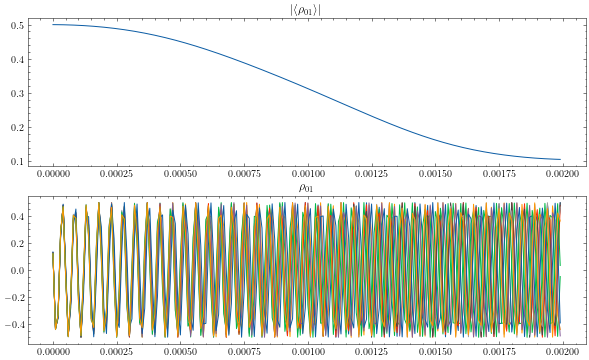

In [24]:
rho_01_ave = np.mean(rho_01s, axis=0)

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2,1,1)
ax1.set_title('$|\\langle \\rho_{01}\\rangle|$')
ax1.plot(t, np.abs(rho_01_ave))

ax2 = fig.add_subplot(2,1,2)
ax2.set_title('$\\rho_{01}$')
ax2.plot(t, rho_01s.T)

plt.show()